# 04 Self‑training on MNIST

Now we run a real self‑training loop and watch it either stabilize or go off the rails.

We’ll compare a no‑threshold run vs a high‑threshold run.



### Early‑state caution

The first round is usually the noisiest — pseudo‑labels are least reliable here.

If you use them too aggressively, error can amplify instead of improve.

Watch how `state_error_e_t` behaves in round 0–1.



### Reading the state‑error plot
In this run, **no‑threshold does not collapse** — it starts noisy but cleans up over rounds.
That can happen on easier tasks like MNIST with a decent model.
The thresholded run stays very clean, but usually accepts far fewer samples early on.
So: **no‑threshold can work**, but **thresholding is the safer default**.

Below we add a harder run to make the failure mode visible.


## Step 1: Imports

We’ll use MNIST, a small CNN, and the self‑training loop.



In [11]:
from pathlib import Path
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent / 'src'))

from utils.seed import set_seed
from data.mnist import get_mnist_ssl
from models.small_cnn import SmallCNN
from methods.self_training import run_self_training


## Step 2: Data setup

We keep labels sparse so the baseline is weak on purpose.



In [12]:
set_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loaders = get_mnist_ssl(
    data_dir='data',
    labeled_per_class=50,
    batch_size=128,
    num_workers=2,
    seed=0,
)


## Step 3: Run two self‑training variants

Compare no‑threshold vs high‑threshold to see stability trade‑offs.



In [13]:
# Baseline self-training (no threshold)
model_a = SmallCNN()
opt_a = torch.optim.Adam(model_a.parameters(), lr=1e-3, weight_decay=5e-4)
result_a = run_self_training(
    model_a,
    loaders.labeled,
    loaders.unlabeled,
    loaders.unlabeled_eval,
    loaders.test,
    opt_a,
    DEVICE,
    rounds=4,
    threshold=0.0,
    use_soft=False,
    max_unlabeled_per_round=10000,
)
# Thresholded self-training
model_b = SmallCNN()
opt_b = torch.optim.Adam(model_b.parameters(), lr=1e-3, weight_decay=5e-4)
result_b = run_self_training(
    model_b,
    loaders.labeled,
    loaders.unlabeled,
    loaders.unlabeled_eval,
    loaders.test,
    opt_b,
    DEVICE,
    rounds=4,
    threshold=0.9,
    use_soft=False,
    max_unlabeled_per_round=10000,
)
# Harder run (fewer labels, higher LR) to expose failure mode
loaders_hard = get_mnist_ssl(
    data_dir='data',
    labeled_per_class=10,
    batch_size=128,
    num_workers=2,
    seed=1,
)
model_h = SmallCNN()
opt_h = torch.optim.Adam(model_h.parameters(), lr=3e-3, weight_decay=1e-4)
result_h = run_self_training(
    model_h,
    loaders_hard.labeled,
    loaders_hard.unlabeled,
    loaders_hard.unlabeled_eval,
    loaders_hard.test,
    opt_h,
    DEVICE,
    rounds=4,
    threshold=0.0,
    use_soft=False,
    max_unlabeled_per_round=10000,
)


## Step 4: Compare test accuracy

Look for fast early gains vs long‑term stability.



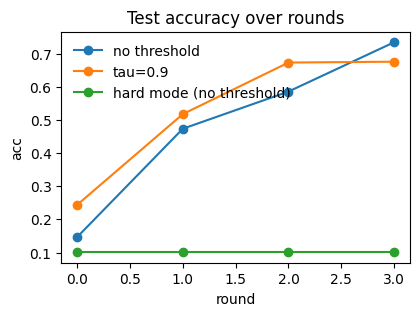

In [14]:
plt.figure(figsize=(4.5, 3))
plt.plot([r['round'] for r in result_a.history], [r['test_acc'] for r in result_a.history], marker='o', label='no threshold')
plt.plot([r['round'] for r in result_b.history], [r['test_acc'] for r in result_b.history], marker='o', label='tau=0.9')
plt.plot([r['round'] for r in result_h.history], [r['test_acc'] for r in result_h.history], marker='o', label='hard mode (no threshold)')
plt.title('Test accuracy over rounds')
plt.xlabel('round')
plt.ylabel('acc')
plt.legend(frameon=False)


## Step 5: Compare state error e_t

If e_t rises, the loop is amplifying mistakes.



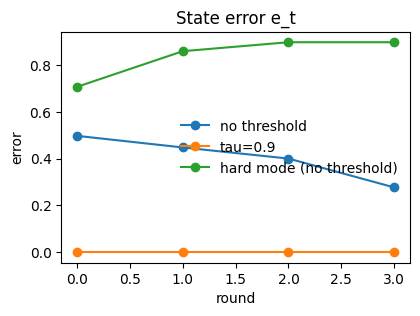

In [15]:
plt.figure(figsize=(4.5, 3))
plt.plot([r['round'] for r in result_a.history], [r['state_error_e_t'] for r in result_a.history], marker='o', label='no threshold')
plt.plot([r['round'] for r in result_b.history], [r['state_error_e_t'] for r in result_b.history], marker='o', label='tau=0.9')
plt.plot([r['round'] for r in result_h.history], [r['state_error_e_t'] for r in result_h.history], marker='o', label='hard mode (no threshold)')
plt.title('State error e_t')
plt.xlabel('round')
plt.ylabel('error')
plt.legend(frameon=False)


### Expected Outcome

Thresholded self‑training should reduce state error and avoid early collapse compared to no threshold.


## Observations → Why → SSL opportunity

**What you’ll likely see**

- No‑threshold may start noisier but can catch up later.

- High threshold starts more conservatively and is often more stable early.

- `state_error_e_t` tells you whether the state is getting cleaner or dirtier.



**Why this happens**

- Early pseudo‑labels are noisy; thresholding reduces noise but slows data usage.

- Depending on seed and difficulty, the no‑threshold run can still recover.



**SSL opportunity**

- Stabilizers keep the recursion safe when the early state is unreliable.

